In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import pickle as pl
from matplotlib.patches import Ellipse
import seaborn as sns
from matplotlib.pyplot import figure

from cpymad.madx import Madx

In [41]:
def generate_particles(madx, number=1000, sigma_x=0.005, sigma_y=0.005, sigma_px=0.00217, sigma_py=0.00217, sigma_t = 0.1, sigma_pt=0.0042):
    """
    Generate particles with coordinates {x,px,y,py,t,pt} for tracking using Gaussian distribution.
    
    :param object madx: instance of Madx class
    :param int number: number of particles to track
    :param float sigma_x: beam x size [m]
    :param float sigma_y: beam y size [m]
    :param float sigma_px: beam relative px size 
    :param float sigma_py: beam relative py size 
    :param float sigma_t: beam longitudinal size [m]
    :param float sigma_pt: beam relative energy spread
    :return: adds particles to Madx ptc_universe
    """
    ## Random numbers generator for Madx
    seed = np.random.randint(0,999999999)
    madx.input('eoption, seed = ' + str(seed) + ', add = True;')
    
    for i in range(number):
        madx.input('ptc_start, x := gauss()*'+ str(sigma_x) + ', y := gauss()*' + str(sigma_y) + ', px := gauss()*' + str(sigma_px) + ', py := gauss()*' + str(sigma_py) + ', t := gauss()*' + str(sigma_t) + ', pt := gauss()*' + str(sigma_pt) + ';')   

In [42]:
def read_tracking_file(file='trackingone.txt'):
    """
    Read a tracking file, which is created after the ptc_track command.
    This file contains information about all particles and their coordinates at every pre-defined location.
    
    :param str file: file name created by Madx ptc_track
    :return list[DataFrame]: list of DataFrames. list size = number of locations. DataFrame size = [number of particles, coordinates]
    """
    table = open(file,'r')
    list_df =[]
    df = pd.DataFrame()
    
    for n, i in enumerate(table):
        ## Drop first 7 unneccessary lines
        if n > 7:            
            if i.split()[0] == '#segment' or i.split()[0] == '':
                if not df.empty:
                    df = df.rename(columns={0: "s", 1: "x", 2: "y", 3: "px", 4: "py", 5: "t", 6: "pt"})
                    list_df.append(df)
                    df = pd.DataFrame()  
                continue  
            df=pd.concat([df,pd.DataFrame(np.array([[float(k) for k in i.split()]]))],ignore_index=True)
    
    df = df.rename(columns={0: "s", 1: "x", 2: "y", 3: "px", 4: "py", 5: "t", 6: "pt"})
    list_df.append(df)
    table.close()
    return list_df

In [54]:
madx = Madx(stdout=True)
madx.option(echo=True, warn=True, info=True, twiss_print=True)
madx.call(file="Beamline_2qdoublets_5m_1.36m.txt") # file with structure

# madx.input('beam, particle = proton, energy = 0.94827, npart = 10e9, ex = 1.1e-5, ey = 1.1e-5, sigt = 0.1, sige = 0.0042;') # for 10 MeV protons
madx.input('beam, particle = ion, energy = 3.76538, mass = 3.72738, charge = 2, npart = 10e9, ex = 1.1e-5, ey = 1.1e-5, sigt = 0.1, sige = 0.0042;') # for 38 MeV alpha particles
madx.input('use, sequence = LINE;')

## Matching
madx.input('match, sequence = LINE, betx = 2.3, alfx = 0, bety = 2.3, alfy = 0;')
madx.input('constraint, sequence = LINE, range = #e, alfx = 0, alfy = 0;')
madx.input('constraint, sequence = LINE, range = #e, betx = 2.3, bety = 2.3;')
madx.input('constraint, sequence = LINE, range = Q1/Q4, betx < 25, bety < 25;')

## Possible constraints
# madx.input('constraint, sequence = LINE, range = #e, dx=0;')
# madx.input('constraint, sequence = LINE, range = B2/O5, betx<10, bety<10;')
# madx.input('constraint, sequence = LINE, range = #s/#e, px<0.001,py<0.001;')
# madx.input('constraint, sequence = LINE, range = #s/#e, betx < 15, bety < 15;')
# madx.input('constraint, sequence = LINE, range = #e, dx=0,dpx=0,dpy=0,dy=0;')
# madx.input('constraint, sequence = LINE, range = #s/#e, px = 0, py = 0;')
# madx.input('constraint, sequence = LINE, range = #e, dpx = 0;')

madx.input('vary, name = Q1->k1, step = 1e-3;')
madx.input('vary, name = Q2->k1, step = 1e-3;')
madx.input('vary, name = Q3->k1, step = 1e-3;')
madx.input('vary, name = Q4->k1, step = 1e-3;')

## Possible parameters to vary
# madx.input('vary, name = Q5->k1, step = 1e-2;')
# madx.input('vary, name = Q6->k1, step = 1e-2;')
# madx.input('vary, name = Q3->L, step = 1e-3;')
# madx.input('vary, name = Q4->L, step = 1e-3;')
# madx.input('vary, name = O5->L, step = 1e-3;')
# madx.input('vary, name = O6->L, step = 1e-3;')
# madx.input('vary, name = O7->L, lower=0.2, upper=1.1, step = 1e-2;')

## Optimizers
madx.input('lmdif, calls=2000, tolerance=1e-15;')
# madx.input('simplex, calls=10000, tolerance=1e-15;')

madx.input('endmatch;')
madx.input('value, Q1->k1; value, Q2->k1;')
madx.input('value, Q3->k1; value, Q4->k1;')
# madx.input('value, Q5->k1; value, Q6->k1;') # for 6 quads only

## PTC tracking
madx.input('use, sequence = LINE1;')
madx.input('ptc_create_universe; ptc_create_layout, time = False, model = 2, method = 6, nst = 10,exact=True;')

generate_particles(madx)
## Add locations (markers) to observe
madx.input('ptc_observe, place=M1; ptc_observe, place=M2; ptc_observe, place=M3; ptc_observe, place=M4;')
madx.input('ptc_observe, place=M5; ptc_observe, place=M6; ptc_observe, place=M7; ptc_observe, place=M8;')
madx.input('ptc_observe, place=M9; ptc_observe, place=M10; ptc_observe, place=M11; ptc_observe, place=M12;')
madx.input('select, flag = track, column = s, x, y, px, py, t, pt;')
madx.input('ptc_track, icase = 5, closed_orbit = false, element_by_element = True, turns = 1, onetable = True, recloss = True, maxaper={0.1,0.1,0.1,1,2} file="tracking",EXTENSION=.txt;')
table = read_tracking_file()

## Coordinates of lost particles
# lost = madx.table.trackloss
# print(lost.x)

## TWISS table
madx.ptc_twiss(icase=5,no=1,closed_orbit = False, table='matrix',file='twiss',betx = 2.3, alfx = 0, bety = 2.3, alfy = 0)
madx.input('readtable,file="twiss",table=matrix1;')

## TWISS parameters [betatron functions, dispersions, alphas]
s = madx.table.matrix1.s
betx = madx.table.matrix1.betx
bety = madx.table.matrix1.bety
dx = madx.table.matrix1.disp1
dy = madx.table.matrix1.disp3
alfx = madx.table.matrix1.alfx
alfy = madx.table.matrix1.alfy
# print('betx:', betx)
# print('bety:', bety)
# print('dx:', dx)
# print('dy:', dy)
# print('alfx:', alfx)
# print('alfy:', alfy)

# madx.input('ptc_track_end;')
# madx.input('stop;')

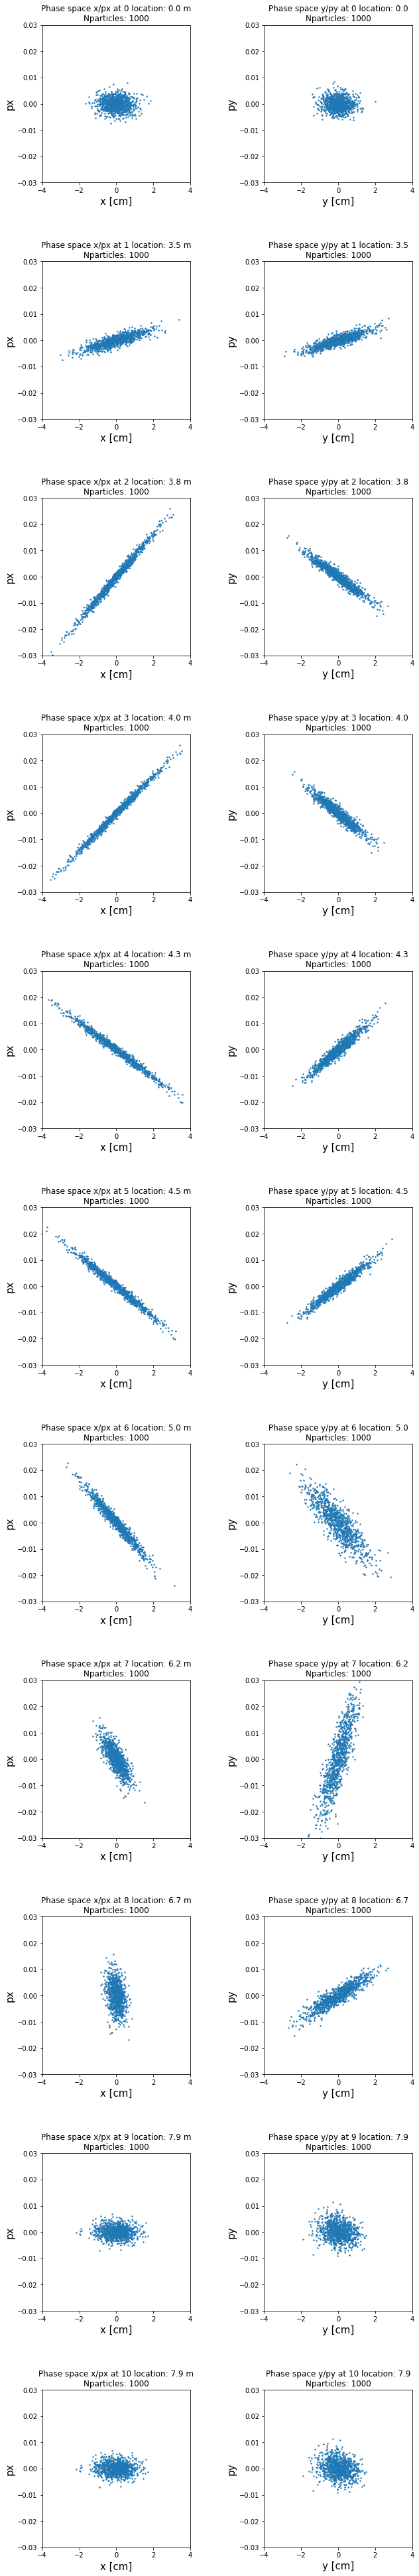

In [55]:
## Visualize beam phase space. For vertical beamline, x becomes y, y becomes x
limit_1 = 4
limit_2 = 3e-2
plt.figure(figsize=(10,70))

for i in range(len(table)):
    plt.subplot(len(table),2,i*2+1)
    plt.title("Phase space x/px at %s location: " % i + str(table[i].s[0]) + ' m\nNparticles: ' + str(table[i].shape[0]))
    plt.scatter(100*table[i].y,table[i].py,s=2)
    plt.xlim(-limit_1, limit_1)
    plt.ylim(-limit_2, limit_2)
    plt.xlabel('x [cm]',size=15)
    plt.ylabel('px',size=15)
    plt.subplots_adjust(hspace=0.5)
    plt.subplots_adjust(wspace=0.5)
    
    plt.subplot(len(table),2,i*2+2)
    plt.title("Phase space y/py at %s location: " % i + str(table[i].s[0]) + '\nNparticles: ' + str(table[i].shape[0]))
    plt.scatter(100*table[i].x,table[i].px,s=2)
    plt.xlim(-limit_1, limit_1)
    plt.ylim(-limit_2, limit_2)
    plt.xlabel('y [cm]',size=15)
    plt.ylabel('py',size=15)
    plt.subplots_adjust(hspace=0.5)
    plt.subplots_adjust(wspace=0.5)

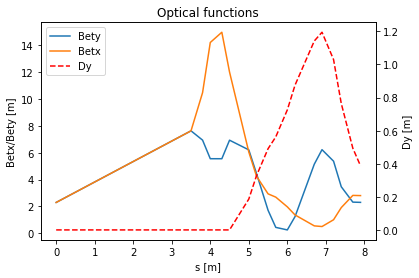

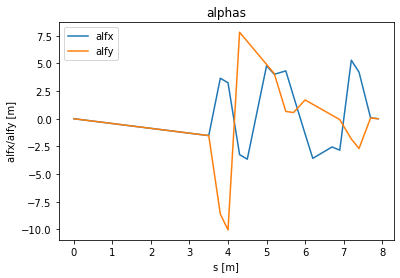

In [56]:
## Visualize optical functions
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(s, betx, label='Bety')
plt.plot(s, bety, label='Betx')
plt.title('Optical functions')
plt.xlabel('s [m]')
plt.ylabel('Betx/Bety [m]')
ax2 = ax.twinx()
ax2.plot(s, dx, label='Dy',c='r', linestyle='dashed')
plt.ylabel('Dy [m]')
fig.legend(loc="upper left",bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)
plt.show()

plt.plot(s, alfx, label='alfx')
plt.plot(s, alfy, label='alfy')
plt.title('alphas')
plt.xlabel('s [m]')
plt.ylabel('alfx/alfy [m]')
plt.legend()
plt.show()

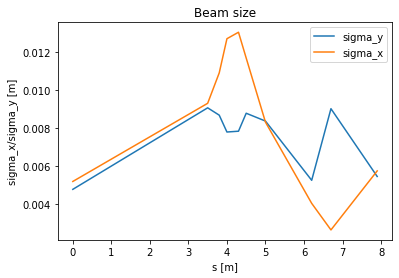

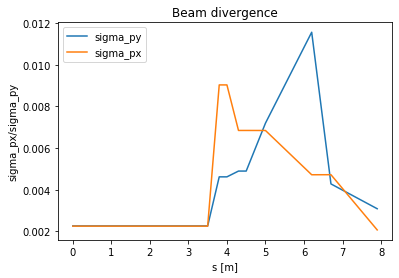

In [57]:
## Visualize beam sizes
size_x = []
size_y = []
size_px = []
size_py = []
mean_x = []
mean_y = []
s_ = []

for i in range(len(table)):
    size_x.append(table[i].x.std())
    size_y.append(table[i].y.std())
    size_px.append(table[i].px.std())
    size_py.append(table[i].py.std())
    mean_x.append(table[i].x.mean())
    mean_y.append(table[i].y.mean())
    s_.append(table[i].s[0])

plt.plot(s_,size_x,label='sigma_y')
plt.plot(s_,size_y,label='sigma_x')
plt.title('Beam size')
plt.xlabel('s [m]')
plt.ylabel('sigma_x/sigma_y [m]')
plt.legend()
plt.show()

plt.plot(s_,size_px,label='sigma_py')
plt.plot(s_,size_py,label='sigma_px')
plt.title('Beam divergence')
# plt.ylim(0,0.014)
plt.xlabel('s [m]')
plt.ylabel('sigma_px/sigma_py')
plt.legend()
plt.show()

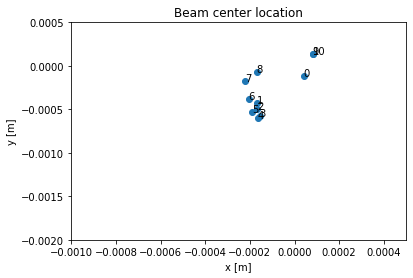

In [58]:
## Visualize coordinates of beam center at each locations
lim = 5e-4
plt.scatter(mean_x,mean_y)
plt.title('Beam center location')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.xlim(-2*lim, lim)
plt.ylim(-4*lim, lim)
for i in range(len(mean_x)):
    plt.text(mean_x[i], mean_y[i], str(i))
plt.show()